# Nonlinear regression with the Gardner equation

We'd like to fit the parameters of a known function, the so-called [Gardner equation](https://www.subsurfwiki.org/wiki/Gardner%27s_equation):

$$ \rho = \alpha \ V_\mathrm{P}^{\,\beta}\ \ \mathrm{kg}/\mathrm{m}^3 $$

Where $\alpha$ and $\beta$ are parameters to fit.

## Load some data

First let's load some data:

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_simple.csv')

df.head()

,Vp,Vs,rho,Lithology
0,3045.6,1595.7,2.109121,sandstone
1,3000.6,1517.1,2.090342,sandstone
2,3363.6,2041.5,2.131990,sandstone
3,3195.3,1606.2,2.184939,sandstone
4,4237.5,2448.6,2.472231,sandstone


### EXERCISE

We need to get the independent data (`x`) and dependent data (`y`) out of here, multiplying `y` by 1000 to convert from units of g/cm<sup>3</sup> to the kg/m<sup>3</sup> required by the equation.

Assign the Vp values to `x` and the rescaled `rho` values to `y`:

In [ ]:
# YOUR CODE HERE



In [21]:
x = df.loc[df['Lithology']=='shale', 'Vp'].values
y = df.loc[df['Lithology']=='shale', 'rho'].values * 1000

x.shape, y.shape

((200,), (200,))

### EXERCISE

Make a scatter plot of `y` vs `x`.

In [32]:
# YOUR CODE HERE



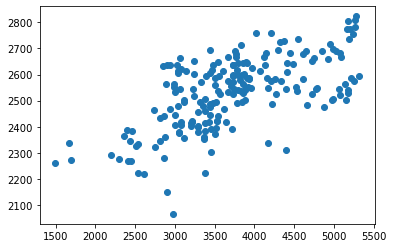

In [22]:
import matplotlib.pyplot as plt

plt.scatter(x, y)

### EXERCISE

Write a function implementing the Gardner equation:

$$ \rho = 310\ V_\mathrm{P}^{\,0.25}\ \ \mathrm{kg}/\mathrm{m}^3 $$

Make your function take Vp as a required argument, and two optional arguments, `alpha` and `beta`, with default values of 310 and 0.25 respectively. 

In [ ]:
# YOUR CODE HERE



In [31]:
def gardner(vp, alpha=310, beta=0.25):
    """Estimate rhob from vp"""
    return alpha * vp**beta

### EXERCISE

Plot the data again, this time overplotting the Gardner relationship using the default values for `alpha` and `beta`. 

In [ ]:
# YOR CODE HERE



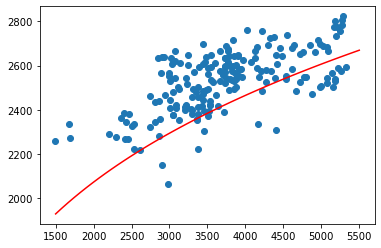

In [26]:
import numpy as np

vp_mod = np.linspace(1500, 5500)
rhob_mod = gardner(vp_mod)

plt.scatter(x, y)
plt.plot(vp_mod, rhob_mod, c='red')

## Using `scipy.optimize`

This package fits any number of parameters to an arbitrary function.

In [39]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(gardner, x, y)

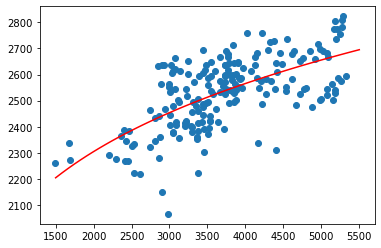

In [40]:
vp_mod = np.linspace(1500, 5500)
rhob_mod = gardner(vp_mod, *popt)

plt.scatter(x, y)
plt.plot(vp_mod, rhob_mod, c='red')

That looks pretty good.

The only thing we might not like is that it's completely outside our Scikit-Learn ecosystem, so we might have to fiddle about a bit to include it in our model selection workflow.

Let's see how to make a Scikit-Learn class that will achieve the same thing, but wrap it up as an `sklearn` estimator.

## Using `sklearn.base.BaseEstimator`

**Note** there are other functions in `sklearn.utils.validation`, such as `check_X_y()` and `check_array()` that you would normally want to use. They don't make sense for us, because we want `X` to be a scalar or 1D array. But if we want to play nicely with other `sklearn` utilities, we'll probably find that we have to expect 2D arrays for `X`.

In [67]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted
from scipy.optimize import curve_fit


class GardnerEstimator(BaseEstimator, RegressorMixin):
    """
    Minimalist example to give our workflow a scikit-learn interface.
    """
    def fit(self, X, y):
        self.coef_, _ = curve_fit(gardner, X, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        return gardner(X, *self.coef_)

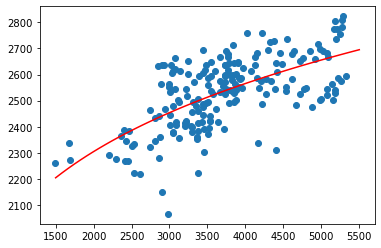

In [68]:
model = GardnerEstimator()

model.fit(x, y)

vp_mod = np.linspace(1500, 5500)
rhob_mod = model.predict(vp_mod)

plt.scatter(x, y)
plt.plot(vp_mod, rhob_mod, c='red')

In [69]:
model.coef_

array([7.10995911e+02, 1.54718165e-01])

---

&copy; 2022 Agile Scientific